4 Задание
1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.
1. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
1. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
1. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
1. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)
1. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import itertools

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.simplefilter('ignore')

## Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [2]:
#Path_Energy = '"D:\AI\Machine learning\my_PJME_MW.csv"
Path_Energy = 'D:/AI/Machine learning/my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head(3)

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0


In [3]:
data_w = data.resample('W').mean()
data_w.tail()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2018-07-08,38459.982143,2018.0,7.000000,5.000000,3.0,186.000000,27.0,3.000000,11.500000,0.142857,0.142857,0.142857
2018-07-15,36420.035714,2018.0,7.000000,12.000000,3.0,193.000000,28.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-07-22,35612.095238,2018.0,7.000000,19.000000,3.0,200.000000,29.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-07-29,36581.821429,2018.0,7.000000,26.000000,3.0,207.000000,30.0,3.000000,11.500000,0.000000,0.000000,0.000000
2018-08-05,36568.804124,2018.0,7.505155,15.865979,3.0,212.525773,31.0,1.525773,11.381443,0.000000,0.000000,0.000000


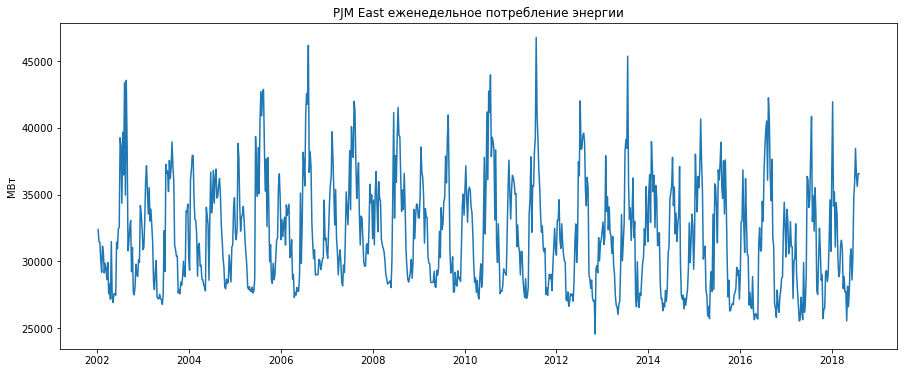

In [4]:
plt.figure(figsize =(15, 6))
plt.plot( data_w.index, data_w['PJME_MW'].values)
plt.title('PJM East еженедельное потребление энергии')
plt.ylabel ('МВт');

## Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

снова построим графики автокорреляции и частичной автокорреляции

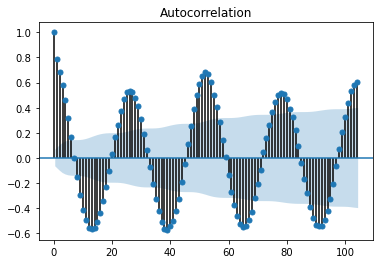

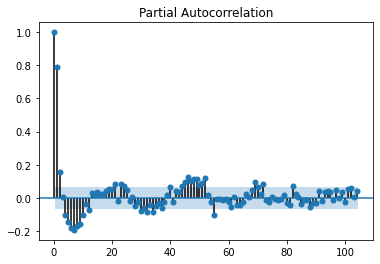

In [5]:
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=52*2)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=52*2)
plt.show()

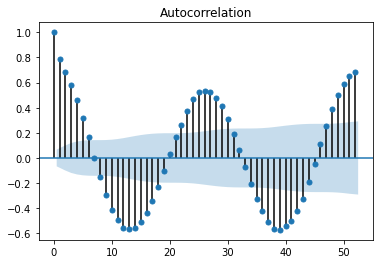

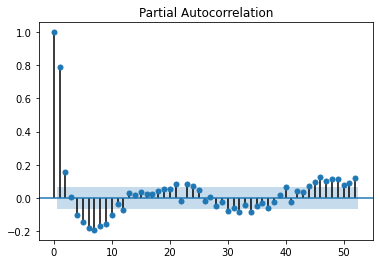

In [6]:
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=52)
plt.show()
sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=52)
plt.show()

Если создавать новые признаки для бустинга, то взяла бы для модели признаки из истории с лагом от 46 до 52,
первые два и с 6 по 9.
Также попробуем ARIMA. При поиске параметров p - до значения 10, q по значение 5

In [7]:
diff_1 = data_w['PJME_MW'].diff(1)
diff_2 = data_w['PJME_MW'].diff(2)

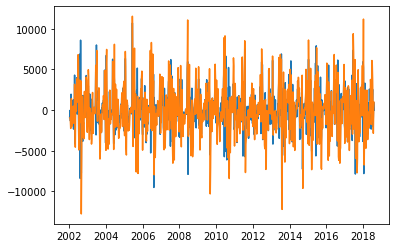

In [8]:
plt.plot(diff_1)
plt.plot(diff_2)

думаю, в отсутствии тренда можно удовлетвориться перебором первых разностей 0 и 1 порядка

In [9]:
#проверить скользящую среднюю окном  7
#roll_1 = data_w['PJME_MW'].values + 0.8*np.roll(data_w['PJME_MW'].values, 7) # + 0.6*np.roll(data_w['PJME_MW'].values,-2) #+ 0.6 *np.roll(data_w['PJME_MW'].values,-3)

In [10]:
#plt.plot(data_w['PJME_MW'].values)
#plt.plot(roll_1)

In [11]:
#lag_pacf = sm.graphics.tsa.plot_pacf(roll_1, lags=60)


In [12]:
p = range(0, 10)
d = range(0, 2)
q = range(0, 6)
p_s = d_s = q_s = range(0, 2)

In [13]:
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))


In [14]:
aic_ = 100000
param_ = None 
#param_seasonal_ = None
for param in pdq:
#    for param_seasonal in seasonal_pdq:
    try:
        mod = ARIMA(data_w['PJME_MW'].values,
                    order=param)
        results = mod.fit()
        if results.aic < aic_:
            aic_ = results.aic
            param_ = param 
                #param_seasonal_ = param_seasonal
    except:
        continue
print('ARIMA {} - AIC: {}'.format(param_,  aic_))

ARIMA (6, 0, 2) - AIC: 15737.815122054002


Также попробуем SARIMA на получше показатель акаика.

In [16]:
# зададим сезонность p, d и q
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p_s, d_s, q_s))]

In [17]:
aic_ = 100000
param_seasonal_ = None
for param_seasonal in seasonal_pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values,
                                order=param_,
                                seasonal_order=param_seasonal ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
            
        results = mod.fit()
        if results.aic < aic_:
            aic_ = results.aic
            param_seasonal_ = param_seasonal
    except:
        continue
print('SARIMAX {} x {} - AIC: {}'.format(param_, param_seasonal_, aic_))

SARIMAX (6, 0, 2) x (1, 1, 1, 52) - AIC: 13876.194240797631


In [18]:
model = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values,
                                order=param_,
                                seasonal_order=param_seasonal ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [19]:
results = model.fit()

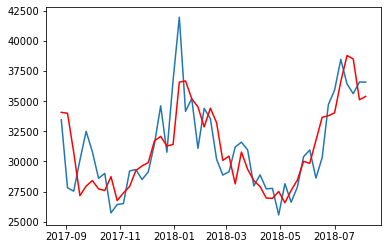

In [20]:
plt.plot(data_w.iloc[-50:,0])
plt.plot(data_w.index[-50:] ,results.fittedvalues[-50:], color='red')

In [21]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

средняя абсолютная ошибка модели SARIMA

In [22]:
mae_sarima = mean_absolute_percentage_error(data_w.iloc[1:,0],results.fittedvalues[1:])
mae_sarima

5.8758298000530305

In [23]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [24]:
df = data_w.copy()

In [25]:
df['exp_0_5'] = exponential_smoothing(df['PJME_MW'], 0.5)

In [26]:
#строим доп признаки соответственно выводам из функции автокорреляции и частичной автокорреляции

In [27]:
df['t_1'] = df['PJME_MW'].shift(periods=1)
df['t_2'] = df['PJME_MW'].shift(periods=2)
df['t_6'] = df['PJME_MW'].shift(periods=6)
df['t_7'] = df['PJME_MW'].shift(periods=7)
df['t_8'] = df['PJME_MW'].shift(periods=8)
df['t_9'] = df['PJME_MW'].shift(periods=9)
df['t_46'] = df['PJME_MW'].shift(periods=46)
df['t_47'] = df['PJME_MW'].shift(periods=47)
df['t_48'] = df['PJME_MW'].shift(periods=48)
df['t_49'] = df['PJME_MW'].shift(periods=49)
df['t_50'] = df['PJME_MW'].shift(periods=50)
df['t_51'] = df['PJME_MW'].shift(periods=51)
df['t_52'] = df['PJME_MW'].shift(periods=52)
df['t_53'] = df['PJME_MW'].shift(periods=53)

In [28]:
df = df.loc[df.index > pd.to_datetime('2003-01-05'), :]

In [29]:
df.head(3)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,...,t_8,t_9,t_46,t_47,t_48,t_49,t_50,t_51,t_52,t_53
Date,,,,,,,,,,,,,,,,,,,,,
2003-01-12,33025.833333,2003.0,1.0,9.0,1.0,9.0,2.0,3.0,11.5,0.000000,...,28881.886905,29018.077381,29144.130952,30616.565476,31150.517857,29196.488095,30141.529762,31452.880952,31487.386905,32392.160839
2003-01-19,35999.547619,2003.0,1.0,16.0,1.0,16.0,3.0,3.0,11.5,0.000000,...,30137.250000,28881.886905,29869.011905,29144.130952,30616.565476,31150.517857,29196.488095,30141.529762,31452.880952,31487.386905
2003-01-26,37169.547619,2003.0,1.0,23.0,1.0,23.0,4.0,3.0,11.5,0.142857,...,29946.190476,30137.250000,29440.910714,29869.011905,29144.130952,30616.565476,31150.517857,29196.488095,30141.529762,31452.880952


In [81]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [103]:
train, test = split_data(df, '2016-07-01')

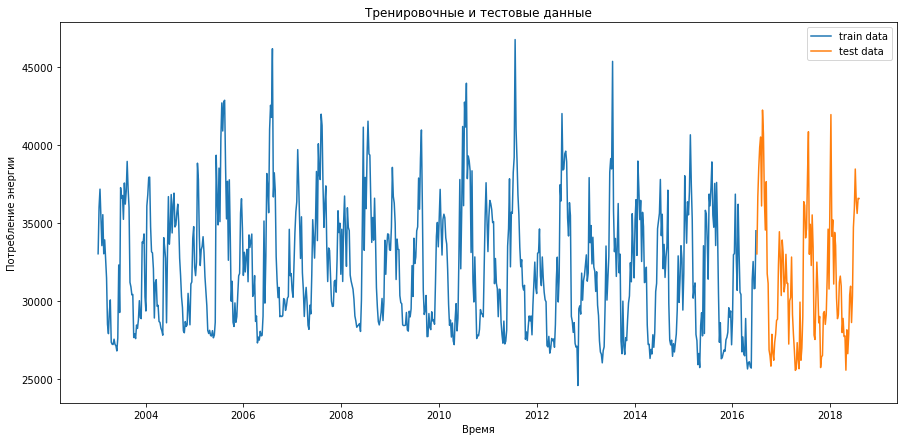

In [104]:
plt.figure(figsize=(15, 7))
plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(train.index.get_level_values('Date'), train[df.columns[0]], label='train data' )
plt.plot(test.index.get_level_values('Date'), test[df.columns[0]], label='test data')
plt.title('Тренировочные и тестовые данные')
plt.legend();

In [105]:
h = 4

In [106]:
X_train_4 = train.iloc[:-h,:]
y_train_4 = train[df.columns[0]].values[h:]
X_test_4 = test.iloc[:-h,:]
y_test_4 = test[df.columns[0]].values[h:]

In [107]:
model_gb = GradientBoostingRegressor(max_depth=3, random_state=0, n_estimators=100)

In [108]:
model_gb.fit(X_train_4, y_train_4) 
X_test_pred_gb = model_gb.predict(X_test_4)

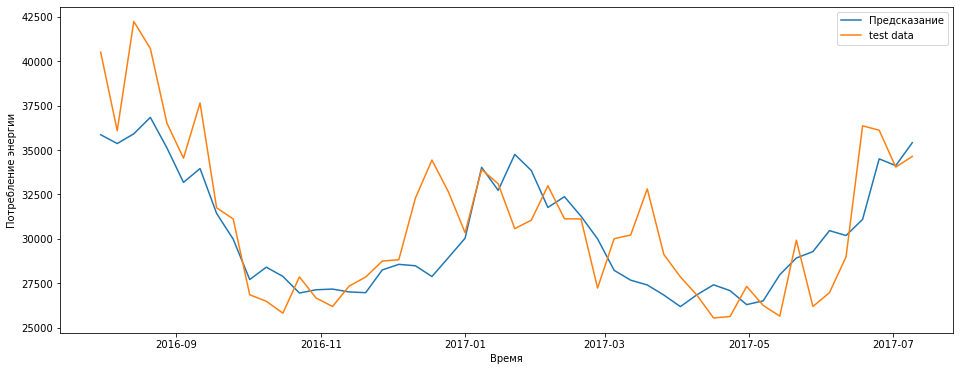

ошибка градиентного бустинга :   6.18409248187853 %


In [109]:
plt.figure( figsize=(16, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h: h + 50], X_test_pred_gb[: 50], label='Предсказание')
plt.plot(test.index[h: h + 50], y_test_4[: 50], label='test data')
plt.legend()
plt.show()

er_g_4 = mean_absolute_percentage_error(y_true=y_test_4, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g_4, '%')

## Постройте модель предсказания 1-й точки от текущей (h = 1), автокорреляционного анализа из предшествующих уроков .

In [110]:
h = 1

In [111]:
X_train_1 = train.iloc[:-h,:]
y_train_1 = train[df.columns[0]].values[h:]
X_test_1 = test.iloc[:-h,:]
y_test_1 = test[df.columns[0]].values[h:]

In [112]:
model_gb.fit(X_train_1, y_train_1) 
X_test_pred_gb_1 = model_gb.predict(X_test_1)

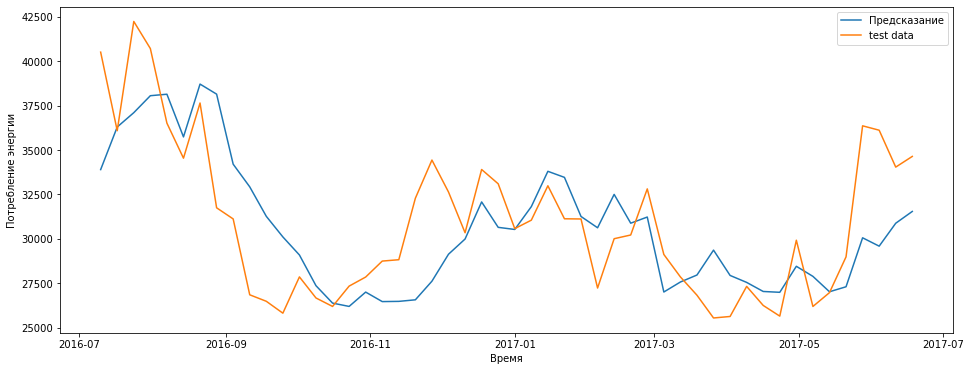

ошибка градиентного бустинга :   5.8849596927271435 %


In [113]:
plt.figure( figsize=(16, 6))

plt.xlabel('Время')
plt.ylabel('Потребление энергии')
plt.plot(test.index[h: h + 50], X_test_pred_gb_1[: 50], label='Предсказание')
plt.plot(test.index[h: h + 50], y_test_4[: 50], label='test data')
plt.legend()
plt.show()

er_g_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=X_test_pred_gb_1)

print('ошибка градиентного бустинга :  ', er_g_1, '%')

Думаю, если добавить признаки первых разностей (первого и второго порядка, как минимум), то градиентный бустинг покажет лучше результаты, чем SARIMA.

**Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.**

In [114]:
n_cols = len(df.columns)
n_cols

27

In [115]:
X_test_rec = X_test_4.copy()
y_test_rec = X_test_pred_gb.copy()

In [116]:
N = 4
for i in range(N):
    y_test_rec[i] = model_gb.predict(X_test_rec.iloc[i, :].values.reshape((1, -1)))
    X_test_rec.iloc[i + 1, 0] = y_test_rec[i]

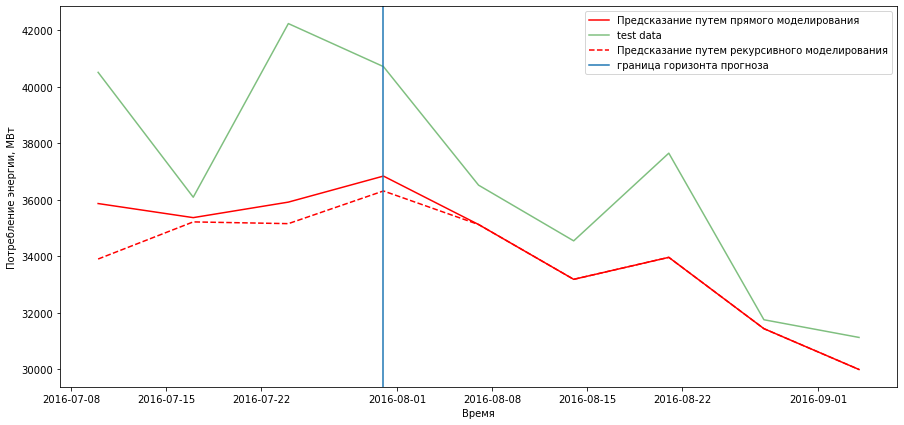

In [117]:
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1: N+6], X_test_pred_gb[:N+5], 'r', label='Предсказание путем прямого моделирования' )
plt.plot(test.index[1: N+6], y_test_4[:N+5], 'g', label='test data', alpha=0.5)
plt.plot(test.index[1: N+6], y_test_rec[:N+5], '--r', label='Предсказание путем рекурсивного моделирования')
plt.axvline(test.index[N], label='граница горизонта прогноза')
plt.legend()
plt.show()    

In [118]:
er_g_rec = mean_absolute_percentage_error(y_true=y_test_4[:N], y_pred=y_test_rec[:N])

print('ошибка градиентного бустинга:  ', er_g_4, '%')
print('ошибка рекурсивного моделирования:  ', er_g_rec, '%')

ошибка градиентного бустинга:   6.18409248187853 %
ошибка рекурсивного моделирования:   11.584862662499448 %


**Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)**

In [120]:
N = 100

for i in range(N):
    y_test_rec[i] = model_gb.predict(X_test_rec.iloc[i, :].values.reshape((1, -1)))
    X_test_rec.iloc[i + 1, 0] = y_test_rec[i]
    

for dec in range(0,100,10):    
    er_g_rec = mean_absolute_percentage_error(y_true=y_test_4[dec:dec+10], y_pred=y_test_rec[dec:dec+10])
    print(f'ошибка рекурсивного моделирования :  {er_g_rec}%')
    print(f'интервал {X_test_4.index[dec]} - {X_test_4.index[dec+10]}')

ошибка рекурсивного моделирования :  10.477100039703483%
интервал 2016-07-03 00:00:00 - 2016-09-11 00:00:00
ошибка рекурсивного моделирования :  7.904619009026173%
интервал 2016-09-11 00:00:00 - 2016-11-20 00:00:00
ошибка рекурсивного моделирования :  8.375469795552082%
интервал 2016-11-20 00:00:00 - 2017-01-29 00:00:00
ошибка рекурсивного моделирования :  4.722359869151925%
интервал 2017-01-29 00:00:00 - 2017-04-09 00:00:00
ошибка рекурсивного моделирования :  7.806302926737752%
интервал 2017-04-09 00:00:00 - 2017-06-18 00:00:00
ошибка рекурсивного моделирования :  14.711243330110296%
интервал 2017-06-18 00:00:00 - 2017-08-27 00:00:00
ошибка рекурсивного моделирования :  5.234015635207805%
интервал 2017-08-27 00:00:00 - 2017-11-05 00:00:00
ошибка рекурсивного моделирования :  10.348184022392548%
интервал 2017-11-05 00:00:00 - 2018-01-14 00:00:00
ошибка рекурсивного моделирования :  5.382467108275528%
интервал 2018-01-14 00:00:00 - 2018-03-25 00:00:00
ошибка рекурсивного моделирования 

**Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.**

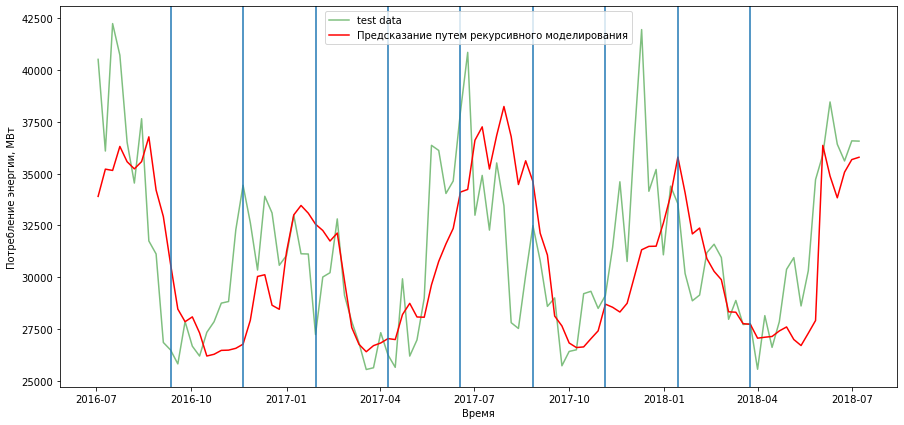

In [123]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(X_test_4.index, y_test_4, 'g', label='test data', alpha=0.5)
plt.plot(X_test_4.index, y_test_rec, 'r', label='Предсказание путем рекурсивного моделирования')
for dec in range(10,100,10):
    plt.axvline(test.index[dec])
plt.legend()
plt.show()   

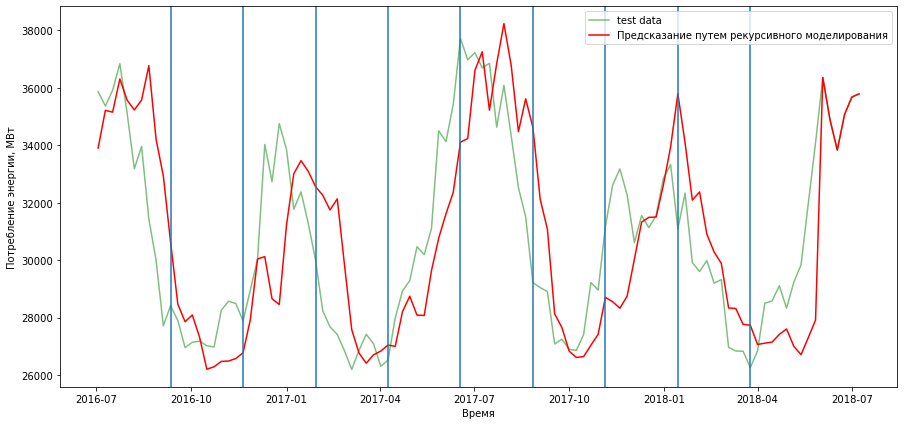

In [125]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(X_test_4.index, X_test_pred_gb, 'g', label='test data', alpha=0.5)
plt.plot(X_test_4.index, y_test_rec, 'r', label='Предсказание путем рекурсивного моделирования')
for dec in range(10,100,10):
    plt.axvline(test.index[dec])
plt.legend()
plt.show()
print()

Первая часть ряда - самое низкое качество предсказания, как и у основной модели. Запаздывание общее у всей основной модели, а у рекурсивной меньше - страдают участки, где наибольшие изменения перед предсказываемым периодом.